
# Stage 09 — Feature Engineering (NYC Subway Delays)

The following notebook implements 3 features that will help us understand teh delay patterns of NYC subway lines.

Features created:
1. `is_weekend` — weekday vs weekend flag  
2. `delay_rate_line` — line-level average delays normalized against system-wide average  
3. `category_flag_infra` — indicator for Infrastructure & Equipment category


## Load Data

In [16]:

import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("data/raw/mta_trains_delayed.csv")
print("Shape:", df.shape)
df.head()


Shape: (40503, 7)


,month,division,line,day_type,reporting_category,subcategory,delays
0,2024-12-01,A DIVISION,1,1,Crew Availability,Crew Availability,83
1,2024-12-01,A DIVISION,1,1,External Factors,External Debris on Roadbed,4
2,2024-12-01,A DIVISION,1,1,Infrastructure & Equipment,Braking,37
3,2024-12-01,A DIVISION,1,1,Infrastructure & Equipment,Door-Related,34
4,2024-12-01,A DIVISION,1,1,Infrastructure & Equipment,"Fire, Smoke, Debris",37



## Feature 1: is_weekend
*Reasoning  
The subway runs on different schedules during weekends and holidays, often with track maintenance and fewer trains. This will often lead to more frequent and longer delays. As such, the following feature will help us distinguish delays on weekdays as compared to delays on weekends, this way we ca speraete the commuter rush hours patterns from the maintenance weekend patterns.

I used a simple binary logic for this part with 0 referring to weekdays and 1 referring to weekend/holiday

 `day_type = 1` → Weekday  
 `day_type = 2` → Weekend/Holiday  


In [17]:

df['is_weekend'] = (df['day_type'] == 2).astype(int)
df[['day_type','is_weekend']].head()


,day_type,is_weekend
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


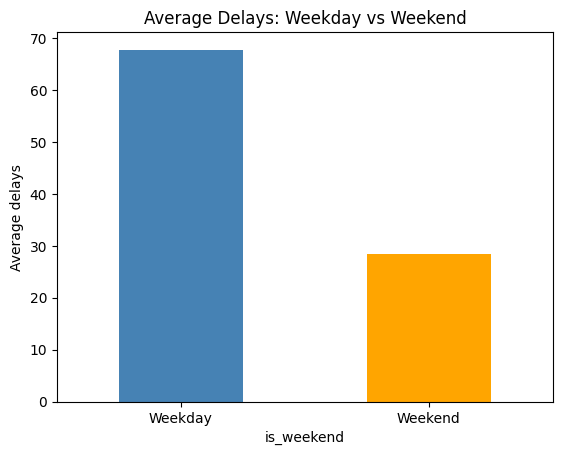

In [18]:

weekend_means = df.groupby('is_weekend')['delays'].mean()
weekend_means.plot(kind='bar', color=['steelblue','orange'])
plt.title("Average Delays: Weekday vs Weekend")
plt.xticks([0,1], ['Weekday','Weekend'], rotation=0)
plt.ylabel("Average delays")
plt.show()


We notice that the average delays are much higher on weekdays compared to weekends. This is consistent with our assumptions since more trains run during the week so more chances of delays. On weekends, fewer trains reduce the number of delay events, though this doesn’t always mean smoother service since scheduled maintenance and longer wait times can still happen and impact riders


## Feature 2 delay_rate_line
Reasoning:  
Some subway lines are more reliable than others and raw delay counts aren’t directly comparable because some lines carry more trains than others

 To compare lines fairly, we normalize each line’s average delays against the overall system average.This way we can get a relative reliability scores that will helpful for commuters to use.

- `delay_rate_line = avg delays for line / avg delays for all lines`


In [19]:

line_avg = df.groupby('line')['delays'].mean()
overall_avg = df['delays'].mean()
df['delay_rate_line'] = df['line'].map(line_avg) / overall_avg
df[['line','delays','delay_rate_line']].head()


,line,delays,delay_rate_line
0,1,83,1.025534
1,1,4,1.025534
2,1,37,1.025534
3,1,34,1.025534
4,1,37,1.025534


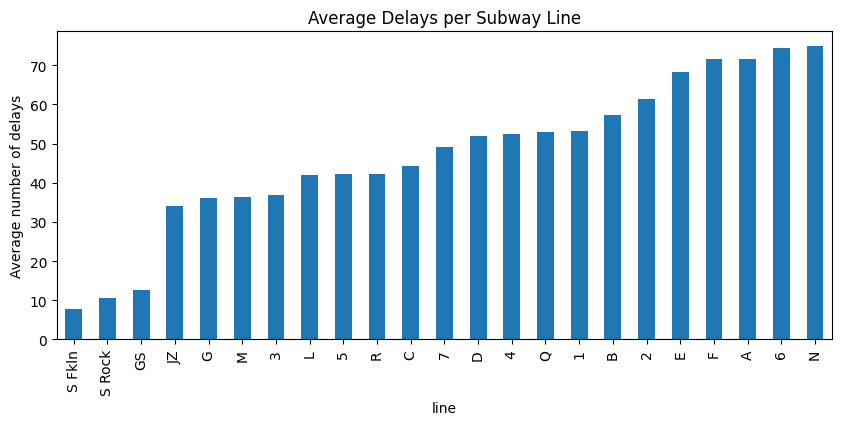

In [20]:

line_means = df.groupby('line')['delays'].mean().sort_values()
plt.figure(figsize=(10,4))
line_means.plot(kind='bar')
plt.title("Average Delays per Subway Line")
plt.ylabel("Average number of delays")
plt.show()


The chart shows that some lines face way more delays than others. Lines like N, 6, and A are at the top with the most delays, while small shuttles like S Franklin and S Rockaway barely have any.This suggests that heavily used, longer routes tend to face more reliability issues, while short shuttle services stay more consistent.


## Feature 3 category_flag_infra
Reasoning:  
Infrastructure & Equipment problems (signals, tracks, trains) are a major cause of delays. This feature helps us understand how impactful these are on the delay of Subway lines. 
Similar to feature 1, I followed a binary logic.

- `category_flag_infra = 1` if reporting_category = *Infrastructure & Equipment*, else 0


In [21]:

df['category_flag_infra'] = (df['reporting_category'] == "Infrastructure & Equipment").astype(int)
df[['reporting_category','category_flag_infra']].head()


,reporting_category,category_flag_infra
0,Crew Availability,0
1,External Factors,0
2,Infrastructure & Equipment,1
3,Infrastructure & Equipment,1
4,Infrastructure & Equipment,1


## Save Processed Data

In [22]:

df_proc = df[['month','division','line','delays','is_weekend','delay_rate_line','category_flag_infra']]
df_proc.to_csv("data/processed/delays_processed.csv", index=False)
df_proc.to_parquet("data/processed/delays_features.parquet", index=False)
print("Processed files saved:")
print("- data/processed/delays_processed.csv")
print("- data/processed/delays_features.parquet")
df_proc.head()


Processed files saved:
- data/processed/delays_processed.csv
- data/processed/delays_features.parquet


,month,division,line,delays,is_weekend,delay_rate_line,category_flag_infra
0,2024-12-01,A DIVISION,1,83,0,1.025534,0
1,2024-12-01,A DIVISION,1,4,0,1.025534,0
2,2024-12-01,A DIVISION,1,37,0,1.025534,1
3,2024-12-01,A DIVISION,1,34,0,1.025534,1
4,2024-12-01,A DIVISION,1,37,0,1.025534,1


Correlation: Understanding how all features work together

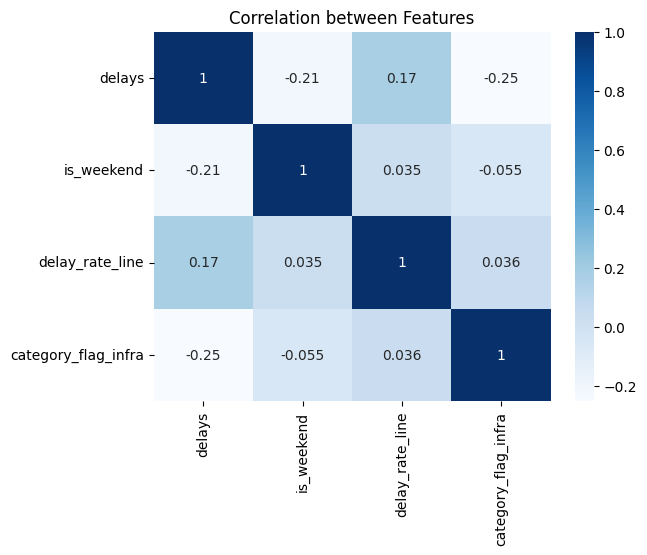

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric engineered features
feat_cols = ['delays','is_weekend','delay_rate_line','category_flag_infra']
sns.heatmap(df[feat_cols].corr(), annot=True, cmap="Blues")
plt.title("Correlation between Features")
plt.show()

This shows that weekday vs weekend has a noticeable effect on delays, since delays are higher during the week. The line-level score also connects to delays, meaning some lines consistently perform worse compared to the sysem average Infrastructure problems appear less tied to the biggest spikes, which suggests other causes also matter. Since the features are not strongly correlated with each other, they each capture a different side of the problem.